In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading keras and FBD experiment...
from keras import backend as K
from helpers import *
from experiment import *
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
import sys
import numpy as np

# to show the model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import Model, Input

# loading resnet
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

Using TensorFlow backend.


Initialized TensorFlow


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 5s 83us/step - loss: 2.3138 - acc: 0.1098 - val_loss: 2.3011 - val_acc: 0.1135
Epoch 2/3
60000/60000 [==============================] - 5s 81us/step - loss: 2.1793 - acc: 0.1681 - val_loss: 0.4174 - val_acc: 0.8720
Epoch 3/3
60000/60000 [==============================] - 5s 80us/step - loss: 0.2723 - acc: 0.9178 - val_loss: 0.0787 - val_acc: 0.9754


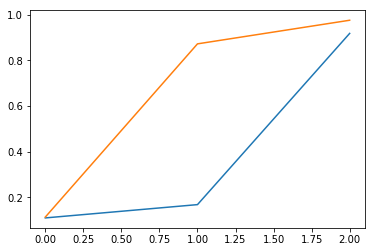

Test loss: 0.07869544848471414
Test accuracy: 0.9754


In [86]:
# see https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='softplus',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='softplus'))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='softplus'))
model.add(Conv2D(64, (3, 3), activation='softplus'))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='softplus'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
plt.figure()
plt.plot(history.history['acc'], label = 'acc')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.show()
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [87]:
# probability of input failure
p = 0.001

In [88]:
# calculating np
np.prod(list(map(int, model.inputs[0].shape[1:]))) * p

0.784

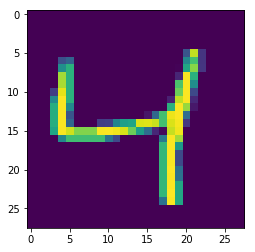

In [89]:
x = np.array([x_train[2]])
plt.imshow(x.reshape(28, 28))

In [90]:
class ModelInputCrashExperiment(Experiment):
    def __init__(self, model, p=0.01, name='exp'):
        """ Get an experiment based on a model, assuming input failures
            p failures at input
        """

        # saving p_inference
        self.p_inference = [0, p]
        
        in_shape = model.layers[0].input.shape[1:]
        out_shape = model.layers[-1].output.shape[1:]
        assert len(out_shape) == 1, "Only support 1D output"
        out_N = int(out_shape[0])

        # rewrite using https://github.com/raghakot/keras-vis/issues/37
        self.N = [0, 0, out_N]

        def IdentityLayer(input_shape=None):
            """ A layer which does nothing """
            return Lambda(
                lambda x: x + 0, input_shape=input_shape, name='Identity')

        # creating correct and crashing models
        inp = Input(shape = in_shape)
        self.model_correct  = Model(inputs = inp, outputs = model(IdentityLayer     (   input_shape = in_shape)(inp)))
        self.model_crashing = Model(inputs = inp, outputs = model(IndependentCrashes(p, input_shape = in_shape)(inp)))

In [91]:
# obtaining experiment from a model
exp = ModelInputCrashExperiment(model, p = p)

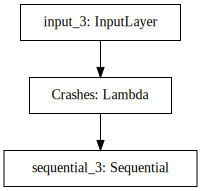

In [92]:
# plotting crashing architecture
SVG(model_to_dot(exp.model_crashing).create(prog='dot', format='svg'))

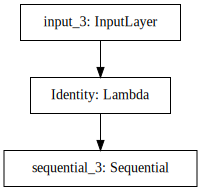

In [93]:
# plotting correct architecture
SVG(model_to_dot(exp.model_correct).create(prog='dot', format='svg'))

In [94]:
def predict(model, x):
    preds = model.predict(x)[0]
    sort = np.argsort(-preds)[:3]
    print(' '.join(['%d: %.20f%%' % (i, 100 * preds[i]) for i in sort]))

In [114]:
predict(exp.model_crashing, x)

4: 99.99458789825439453125% 9: 0.00380352939828298986% 2: 0.00154218087118351832%


In [115]:
predict(exp.model_correct, x)

4: 99.99606609344482421875% 9: 0.00251223591476446018% 2: 0.00137957495098817162%


In [116]:
exp.get_bound_b3(x)['mean']

array([ 3.3809990e-12,  2.7856153e-10,  1.5450233e-07,  2.0372997e-09,
       -4.0790033e-07,  2.3449689e-10,  3.4189032e-10,  3.6633345e-09,
        9.7196140e-11,  2.4693006e-07], dtype=float32)

In [118]:
np.mean(exp.compute_error(np.array(x), repetitions = 100000), axis = 1)

array([[ 5.2915840e-12,  4.2566181e-10,  2.2281540e-07,  3.0880416e-09,
        -5.7124731e-07,  3.6956849e-10,  5.1005300e-10,  5.3649267e-09,
         1.6160433e-10,  3.3934302e-07]], dtype=float32)